Read 1 wsi images: 


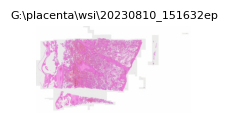

In [1]:
##########################################################################################################
# Author: Mihaly Sulyok & Peter Karacsonyi                                                               #
# Last updated: 2023 Dec 10                                                                              #
# This workbook does wsi preprocessing with Pathml version 2.1.1                                         #
# Input: wsi image files, tested with OpenSlide .tif                                                     #
# Transformations: MedianBlur, BinaryThreshold, Tiling, MorphOpen, MorphClose, ForegroundDetection       #
# Read more on transformations: https://pathml.readthedocs.io/en/latest/examples/link_gallery.html       #
# Output: h5path files (https://pathml.readthedocs.io/en/latest/h5path.html)                             #
##########################################################################################################

# local imports
import os
if os.name == 'nt':
    import helpers.openslideimport #on windows, openslide needs to be installed manually, check local openslideimport.py

# global imports
import time
from pathlib import Path
import matplotlib.pyplot as plt

# pathml imports
from pathml import types
from pathml.core import SlideData, SlideDataset
from pathml.preprocessing import Pipeline, TissueDetectionHE


#########
# usage #
#########

#####################
# configure folders #
#####################

# set working directory
base_dir = Path("G:\\placenta") # "/mnt/g/xyz/" for linux
# wsi folder
wsi_subfolder = "wsi"
# place geojsons into this folder inside base with same name as the image (echino23.tiff / echino23.gejson)
annotations_subfolder = "annotations"
# output h5path files to (will be created)
h5path_subfolder = "h5"
# filenames having this substring with endpoint
endpoint_filename = "endpoint"

#######################################
# configure transformation parameters #
#######################################

pipeline = Pipeline([
    # values are the best found for placenta wsis
    TissueDetectionHE(
        mask_name = "tissue", 
        min_region_size=500,
        outer_contours_only=False,
        morph_n_iter=5,
        morph_k_size=15,
        drop_empty_tiles = False,
        use_saturation = True
    )
])

# relative directory generation (don't modify)
data_dir = base_dir / Path(wsi_subfolder)                       # input
h5_dir = base_dir / Path(h5path_subfolder)                      # output
h5_dir.mkdir(0o644, parents=True, exist_ok=True)                # create if does not exist

# read wsi files
wsi_paths = list(data_dir.glob("*.tif*"))
wsi_list = []
label = {}
for wsi in wsi_paths:
    # label preparation based on filename
    if endpoint_filename in wsi.name.lower():
        label["class"] = 1
    else: 
        label["class"] = 0
    label["wsi_name"] = wsi.name.lower().split(".")[0]
    # read them with openslide HE backend, add labels
    wsi_list.append(
        SlideData(
            str(wsi), 
            name = str(wsi).split(".")[0], 
            backend = "openslide", 
            slide_type = types.HE,
            labels = label,
            tile_size = 500,
            tile_level = 0
        )
    )

slide_dataset = SlideDataset(wsi_list)

# Draw the images
print(f"Read {len(slide_dataset)} wsi images: ")
for slide in slide_dataset:
    _, axs = plt.subplots(figsize=(2, 2))
    slide.plot(ax=axs)
    axs.set_title(label=slide.name, fontsize=8)

In [2]:
# run preprocessing pipeline
start_time = time.time()
slide_dataset.run(
    pipeline,
    distributed=False, # windows OpenSlide DLL error can be fixed by importing into core.py
    write_dir=str(h5_dir), # The write_dir is buggy: places h5path files to wsi folder
)

print(f"Total number of tiles extracted: {sum(len(slide.tiles.keys) for slide in slide_dataset.slides)}")

# move h5path files to h5 dir
h5_paths = list(data_dir.glob("*.h5path"))
for h5file in h5_paths:
    h5file.replace(h5_dir/h5file.name); print(h5_dir/h5file.name)

time_elapsed = time.time() - start_time
print('Preprocessing completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Total number of tiles extracted: 46368
G:\placenta\h5\20230810_151632ep.h5path
Preprocessing completed in 95m 15s
